<a href="https://colab.research.google.com/github/mathengem/Algorithmic-Trading-Backtesting-in-python/blob/main/Copy_of_2_Trading_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Trading algorithm that 'doesn't work'

1. Signup to broker Web-api
2. Create telegram channel and bot (notifications)
3. Define Screener (function with conditions for seeking stocks on the market)
4. Retrieve the data from NN (predictions)
5. Trade with the market itself

In [1]:
!pip install alpaca_trade_api
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Successfully uninstalled msgpack-1.0.8
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=a58d5b08bc8a784d5840d30d97d5c09e6d26ea0f8875ac85ad3e611a154e9661
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import requests as rq
import alpaca_trade_api as api
import yfinance as yf
import pandas_ta as ta

In [3]:
# SETTINGS
TRADER_BOT_NAME = 'Medium trading bot'

TRADER_API_KEY = 'PKZUWPDI2JUJROBPDTO1'
TRADER_API_SECRET = 'QK3v9j6eRinlRixWbmzKFZns7MeWm4mcS4UU23Vx'
TRADER_API_URL = 'https://paper-api.alpaca.markets'

TELEGRAM_URL = 'https://api.telegram.org'
TELEGRAM_BOT_ID = 'bot7453836393:AAEuqnHSZUV6zYR4c29i2yjct-wvCErIkKI' # Medium trading bot
TELEGRAM_CHAT_ID = '-5596994127' # Medium trading bot channel

SCREENER_INTERVAL = '5m'
SCREENER_PERIOD = '1d'
SCREENER_NASDAQ_COUNT = 500

TAKE_PROFIT_DELTA = 0.01
CASH_LIMIT = 26000

In [4]:
# Send message to Telegram channel
def send_message(message):
  response = rq.post(
        f'{TELEGRAM_URL}/{TELEGRAM_BOT_ID}/sendMessage?chat_id={TELEGRAM_CHAT_ID}&parse_mode=Markdown&text={message}')

  return response

In [5]:
# Check stock with TA indicators
def CheckStock(stock):
  data = {}
  try:
    df = yf.download(stock, period = SCREENER_PERIOD, interval = SCREENER_INTERVAL)
    if (len(df) > 0):
      df['RSI'] = ta.rsi(df['Close'], timeperiod=14)
      bbands = ta.bbands(df['Close'], length = 20, std=2.3)
      df['L'] = bbands['BBL_20_2.3']
      df['M'] = bbands['BBM_20_2.3']
      df['U'] = bbands['BBU_20_2.3']

      previous2_bar = df[-3:].head(1)
      previous_bar = df[-2:].head(1)
      current_bar = df[-1:]

      if current_bar['RSI'].values[0] > 70 and \
          current_bar['Close'].values[0] > current_bar['U'].values[0]:
            data = { 'direction': 'DOWN', 'stock' : stock, 'stop_loss': round(max(previous_bar['High'].values[0], previous2_bar['High'].values[0], previous_bar['U'].values[0]), 2), \
                    'take_profit': round(min(previous_bar['Low'].values[0], previous2_bar['Low'].values[0], previous_bar['M'].values[0]), 2) }
      elif current_bar['RSI'].values[0] < 30 and \
            current_bar['Close'].values[0] < current_bar['L'].values[0]:
              data = { 'direction': 'UP', 'stock' : stock, 'stop_loss': round(min(previous_bar['Low'].values[0], previous2_bar['Low'].values[0], previous_bar['L'].values[0]), 2), \
                      'take_profit': round(max(previous_bar['High'].values[0], previous2_bar['High'].values[0], previous_bar['M'].values[0]), 2) }
  except:
    pass

  return data

In [6]:
# Screen stocks
def ScreenStocks(trader_api):
  assets = trader_api.list_assets(status='active', asset_class='us_equity')
  assets = [x for x in assets if x.shortable == True and x.exchange == 'NASDAQ']
  stocks = [x.symbol for x in assets][:SCREENER_NASDAQ_COUNT]

  screened = []
  for st in stocks:
    _stock = CheckStock(st)
    if _stock != {}:
      screened.append(_stock)

  screened = [x for x in screened if abs(x['stop_loss'] - x['take_profit']) > min(x['stop_loss'], x['take_profit']) * TAKE_PROFIT_DELTA]
  return screened

In [7]:
# Get predictions from LSTM neural network
def Predict(stock):
  predictions = [100.24, 155.33, 140.55]

  # Here we have to organize communication between our algorithm and LSTM Model \
  # to get predictions by ticker for the particular stock.
  # But this is the question to the infrastructure.
  # I am gonna consider it in the next article "Infrastructure itself".

  return predictions

In [8]:
# Trade with STOP_LOSS and TAKE_PROFIT
def Trade(api, stock, operation, shares_to_trade, take_profit, stop_loss):
  api.submit_order(symbol = stock, qty = shares_to_trade, side = operation, type = 'market',
                  order_class = 'bracket', time_in_force = 'day',
                  take_profit = {'limit_price': take_profit},
                  stop_loss = {'stop_price': stop_loss})
  message = f'\n\t*{stock}*, qty _{shares_to_trade}_ \n\t\twere {operation}'
  send_message(f'{TRADER_BOT_NAME}: we entered the market with:' + message)
  return True

In [9]:
# MAIN script
def medium_trader_go(request):
  trader_api = api.REST(TRADER_API_KEY, TRADER_API_SECRET, TRADER_API_URL)
  account = trader_api.get_account()
  clock = trader_api.get_clock()

  if bool(account) == True:
    message = f'''{TRADER_BOT_NAME}: for *{account.account_number}*
    current capital is _{account.portfolio_value}$_
    and non marginable buying power is _{account.non_marginable_buying_power}$_'''
    send_message(message)

  if clock.is_open == True:
    if float(account.non_marginable_buying_power) < CASH_LIMIT:
      message = f"{TRADER_BOT_NAME}: there is no cash on the account or limit reached!"
      send_message(message)
    else:
      # Screen stocks
      screened = ScreenStocks(trader_api)
      # Check limit and trade
      if len(screened) > 0:
        CASH_FOR_TRADE_PER_SHARE = (float(account.non_marginable_buying_power) - CASH_LIMIT) / len(screened)
        for item in screened:
          predictions = Predict(item['stock'])
          STOCK = item['stock']
          OPERATION = 'buy' if item['direction'] == 'UP' else 'sell'
          STOP_LOSS = min([item['stop_loss']] + predictions) if item['direction'] == 'UP' else max([item['stop_loss']] + predictions)
          TAKE_PROFIT = max([item['take_profit']] + predictions) if item['direction'] == 'UP' else min([item['take_profit']] + predictions)
          SHARE_PRICE = round(min(STOP_LOSS, TAKE_PROFIT), 2)
          SHARES_TO_TRADE = int(CASH_FOR_TRADE_PER_SHARE / SHARE_PRICE)
          try:
            if abs(STOP_LOSS - TAKE_PROFIT) > SHARE_PRICE * TAKE_PROFIT_DELTA and SHARES_TO_TRADE > 0:
              Trade(api, STOCK, OPERATION, SHARES_TO_TRADE, TAKE_PROFIT, STOP_LOSS)
              print(f'\n{STOCK}: {STOP_LOSS}, {TAKE_PROFIT}, {OPERATION}, {SHARES_TO_TRADE}')
          except:
            pass

  portfolio = trader_api.list_positions()
  if bool(portfolio) == True:
    message = f'{TRADER_BOT_NAME}: we have {len(portfolio)} opened positions.'
    for i in portfolio:
      message = message + f'\n\t*{i.symbol}*: qty {i.qty} {i.side} for _{i.market_value}$_ \n\t\t\tcurrent price _{i.current_price}$_ \n\t\t\tprofit _{i.unrealized_pl}$_'
    send_message(message)

  if clock.is_open == False:
    message = f"{TRADER_BOT_NAME}: the market is *CLOSED*, let's try later on!"
    send_message(message)

  return f'{TRADER_BOT_NAME}: DONE!'

In [10]:
medium_trader_go({})

'Medium trading bot: DONE!'

# 2. Experiments with stock market data
**this part doesn't relate to bot's work exactly**

In [11]:
trader_api = api.REST(TRADER_API_KEY, TRADER_API_SECRET, TRADER_API_URL)
screened = ScreenStocks(trader_api)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$TCBC: possibly delisted; No price data found  (period=1d)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$HAIA: possibly delisted; No price data found  (period=1d)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IPXX']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (period=1d)')
[*********************100%%**********************]  1 of 1 completed

$IPXX: possibly delisted; No price data found  (period=1d)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [12]:
screened

[{'direction': 'UP', 'stock': 'GERN', 'stop_loss': 4.53, 'take_profit': 4.61},
 {'direction': 'DOWN', 'stock': 'NKTX', 'stop_loss': 6.08, 'take_profit': 6.0},
 {'direction': 'UP', 'stock': 'NFE', 'stop_loss': 20.82, 'take_profit': 21.1},
 {'direction': 'UP', 'stock': 'HUMA', 'stop_loss': 4.96, 'take_profit': 5.04},
 {'direction': 'UP', 'stock': 'MREO', 'stop_loss': 3.55, 'take_profit': 3.6},
 {'direction': 'DOWN',
  'stock': 'METCB',
  'stop_loss': 10.94,
  'take_profit': 10.73},
 {'direction': 'UP',
  'stock': 'KURA',
  'stop_loss': 20.68,
  'take_profit': 20.94},
 {'direction': 'UP', 'stock': 'GMGI', 'stop_loss': 2.55, 'take_profit': 2.65}]

[*********************100%%**********************]  1 of 1 completed


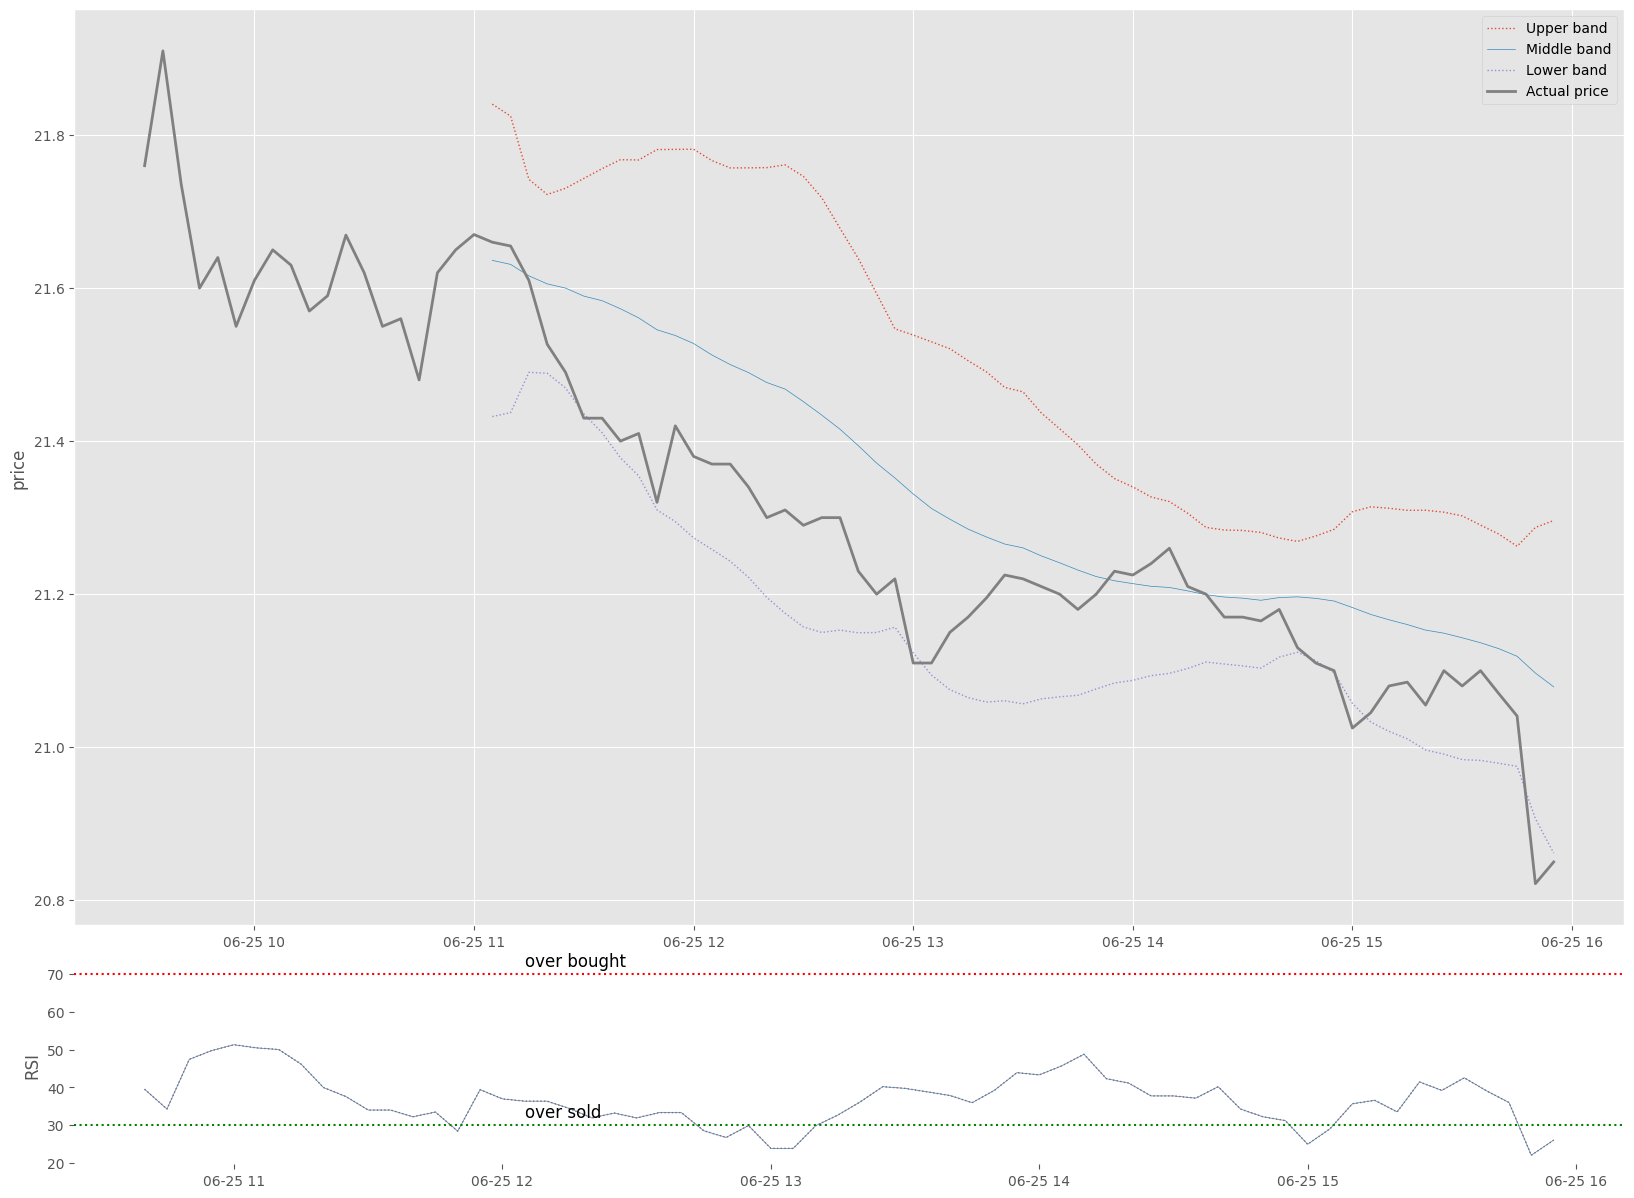

In [13]:
df = yf.download('NFE', period = SCREENER_PERIOD, interval = SCREENER_INTERVAL)
if (len(df) > 0):
  df['RSI'] = ta.rsi(df['Close'], timeperiod=14)
  bbands = ta.bbands(df['Close'], length = 20, std=2.3)
  df['L'] = bbands['BBL_20_2.3']
  df['M'] = bbands['BBM_20_2.3']
  df['U'] = bbands['BBU_20_2.3']

import matplotlib.pyplot as plt

plt.style.use(style='ggplot')
fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot2grid((5,1), (0,0), colspan=1, rowspan=4)
ax1.plot(df['U'],linewidth=1, linestyle='dotted')
ax1.plot(df['M'],linewidth=0.5)
ax1.plot(df['L'],linewidth=1, linestyle='dotted')
ax1.plot(df['Close'],linewidth=2, color='grey')
ax1.set_ylabel('price')
ax1.legend(['Upper band',
            'Middle band',
            'Lower band',
            'Actual price'])

ax2 = plt.subplot2grid((5,1), (4,0), colspan=1, rowspan=1, frameon=False)
ax2.plot(df['RSI'],linewidth=1, linestyle='dotted')
ax2.plot(df['RSI'],linewidth=0.5)
ax2.text(s='over bought', x=df['RSI'].index[31], y=72, fontsize=12)
ax2.text(s='over sold', x=df['RSI'].index[31], y=32, fontsize=12)
ax2.axhline(y=70, color='red', linestyle='dotted')
ax2.axhline(y=30, color='green', linestyle='dotted')
ax2.grid()
ax2.set_ylabel('RSI')
plt.show()